In [ ]:
# !pip install torch datasets transformers numpy pandas scipy matplotlib


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import spearmanr, pearsonr
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import json
import time
import random
import os
from joblib import Parallel, delayed
import multiprocessing

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
multiprocessing.set_start_method("spawn", force=True)

In [4]:
device = 'cpu'

In [5]:
# torch.cuda.empty_cache()

In [6]:
# this isn't much faster on GPU

# if torch.cuda.is_available():
#     print("CUDA is available!")
#     device = torch.device("cuda")
# else:
#     print("CUDA is not available. Running on CPU.")
#     device = torch.device("cpu")

In [7]:
# load a wikipedia dataset
dataset = load_dataset("tcltcl/inuit-and-truncated-american-wikipedia", trust_remote_code=True)


In [8]:
# load a small pretrained GPT model and tokenizer
model_name = "EleutherAI/gpt-neo-125M"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# use the eos token as padding
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))
model = model.to(device)
model.eval()

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_fe

In [9]:
dataset.keys()

dict_keys(['train'])

In [10]:
print("Tokenizer vocab size:", len(tokenizer))
print("Model vocab size:", model.config.vocab_size)


Tokenizer vocab size: 50257
Model vocab size: 50257


In [11]:
# dir(model.config)

In [12]:
model.config.max_position_embeddings

2048

In [13]:
max_length = 2048  # model's max length
stride = 1024  # set stride between overlapping chunks of text tokens
context_buffer = 32  # number of tokens from left-side context each chunk
chunked_tokens = []  # tokenized chunks
center_positions = []  # central part of each chunk
# model config token padding
model.config.pad_token_id = tokenizer.pad_token_id
max_input_length = model.config.max_position_embeddings 
# tokenize data to have consistent sequence length
for item in dataset["train"]:
    # get text
    text = item["text"]
    # tokenize as 1D list (no batches)
    tokens = tokenizer(text, return_tensors="pt", truncation=False)["input_ids"].squeeze(0)
    token_length = len(tokens)

    # make overlapping sliding window chunks of text
    for i in range(0, token_length, stride):
        # include left context in window, but stay in bounds
        start = max(i - context_buffer, 0)
        end = min(start + max_input_length, token_length)  # end of chunk, within max 
        
        token_chunk = tokens[start:end]  # get chunk slice

        # double check no chunk exceeds model limit
        assert len(token_chunk) <= max_input_length, f"chunk too long: {len(token_chunk)}"

        chunked_tokens.append(token_chunk)
        center_start = i - start  # get center tokens in chunk
        center_end = min(center_start + stride, len(token_chunk))
        center_positions.append((center_start, center_end))


Token indices sequence length is longer than the specified maximum sequence length for this model (3721 > 2048). Running this sequence through the model will result in indexing errors


In [14]:
tokenizer('inuit')

{'input_ids': [259, 5013], 'attention_mask': [1, 1]}

In [15]:
tokenizer.decode([259])

'in'

In [16]:
tokenizer.decode([5013])

'uit'

In [17]:
tokenizer('american')

{'input_ids': [2382, 7490], 'attention_mask': [1, 1]}

In [18]:
tokenizer.decode([2382])

'amer'

In [19]:
tokenizer.decode([7490])

'ican'

In [20]:
tokenizer('ced')

{'input_ids': [771], 'attention_mask': [1]}

In [21]:
tokenizer.decode([771])

'ced'

In [22]:
# get LLM hidden activations
def get_activations(tokenized_inputs, model, layer_idx=0, batch_size=16):
    all_activations = []
    for i in range(0, len(tokenized_inputs), batch_size):
        batch_tokens = tokenized_inputs[i:i+batch_size]
        # pad sequences
        batch_tokens = torch.nn.utils.rnn.pad_sequence(
            batch_tokens, batch_first=True, padding_value=tokenizer.pad_token_id
        )
        batch_tokens = batch_tokens.to(model.device)
        with torch.no_grad():
            outputs = model(input_ids=batch_tokens, output_hidden_states=True)
        act = outputs.hidden_states[layer_idx].cpu()  # get layer activations
        all_activations.append(act)
        # torch.cuda.empty_cache()
    return torch.cat(all_activations, dim=0)  # concat along sequence axis


In [23]:
# get middle layer activations
activations = get_activations(chunked_tokens, model, layer_idx=5)

In [24]:
# set seeds for reproducibility
seed = 4  
random.seed(seed)

np.random.seed(seed)
torch.manual_seed(seed)

# if using GPU
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [25]:
# top k sparse autoencoder
# k determines number of latent activations to keep
class TopKSparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, k):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)

        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.k = k
    
    def forward(self, x): 

        encoded = torch.relu(self.encoder(x))
        # select the top k activations
        topk_values, topk_indices = torch.topk(encoded, self.k, dim=-1)
        # mask where only top k values are 1, in the last dimension
        mask = torch.zeros_like(encoded).scatter_(-1, topk_indices, 1)
        # zero non top k activations
        sparse_encoded = encoded * mask 
        decoded = self.decoder(sparse_encoded)
        return decoded, sparse_encoded


In [26]:
# train SAE
input_dim = activations.shape[-1]  # layer activations size
expansion_factor = 4  # expand activations by this multiple 
hidden_dim = input_dim * expansion_factor  
k = 16  # top k activations to keep
sae = TopKSparseAutoencoder(input_dim, hidden_dim, k).to(device) 
# update sae parameters
optimizer = optim.Adam(sae.parameters(), lr=0.001)
criterion = nn.MSELoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.01)

def train_sae(sae, activations, epochs=200):
    activations = activations.to(device) 
    # Normalize activations before training
    mean = activations.mean(dim=0, keepdim=True)
    std = activations.std(dim=0, keepdim=True) + 1e-6  # avoid div by zero
    activations = (activations - mean) / std

    for epoch in range(epochs):
        optimizer.zero_grad()
        decoded, encoded = sae(activations)
        loss = criterion(decoded, activations)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
            
    print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

train_sae(sae, activations)

Epoch 0: Loss = 0.9910
Epoch 10: Loss = 0.6628
Epoch 20: Loss = 0.4759
Epoch 30: Loss = 0.3968
Epoch 40: Loss = 0.3490
Epoch 50: Loss = 0.3182
Epoch 60: Loss = 0.2969
Epoch 70: Loss = 0.2813
Epoch 80: Loss = 0.2691
Epoch 90: Loss = 0.2593
Epoch 100: Loss = 0.2513
Epoch 110: Loss = 0.2445
Epoch 120: Loss = 0.2386
Epoch 130: Loss = 0.2336
Epoch 140: Loss = 0.2291
Epoch 150: Loss = 0.2252
Epoch 160: Loss = 0.2216
Epoch 170: Loss = 0.2185
Epoch 180: Loss = 0.2157
Epoch 190: Loss = 0.2131
Epoch 199: Loss = 0.2110


In [27]:
"""
Epoch 0: Loss = 0.9910
Epoch 10: Loss = 0.6628
Epoch 20: Loss = 0.4759
Epoch 30: Loss = 0.3968
Epoch 40: Loss = 0.3490
Epoch 50: Loss = 0.3182
Epoch 60: Loss = 0.2969
Epoch 70: Loss = 0.2813
Epoch 80: Loss = 0.2691
Epoch 90: Loss = 0.2593
Epoch 100: Loss = 0.2513
Epoch 110: Loss = 0.2445
Epoch 120: Loss = 0.2386
Epoch 130: Loss = 0.2336
Epoch 140: Loss = 0.2291
Epoch 150: Loss = 0.2252
Epoch 160: Loss = 0.2216
Epoch 170: Loss = 0.2185
Epoch 180: Loss = 0.2157
Epoch 190: Loss = 0.2131
Epoch 199: Loss = 0.2110
"""

'\nEpoch 0: Loss = 0.9910\nEpoch 10: Loss = 0.6628\nEpoch 20: Loss = 0.4759\nEpoch 30: Loss = 0.3968\nEpoch 40: Loss = 0.3490\nEpoch 50: Loss = 0.3182\nEpoch 60: Loss = 0.2969\nEpoch 70: Loss = 0.2813\nEpoch 80: Loss = 0.2691\nEpoch 90: Loss = 0.2593\nEpoch 100: Loss = 0.2513\nEpoch 110: Loss = 0.2445\nEpoch 120: Loss = 0.2386\nEpoch 130: Loss = 0.2336\nEpoch 140: Loss = 0.2291\nEpoch 150: Loss = 0.2252\nEpoch 160: Loss = 0.2216\nEpoch 170: Loss = 0.2185\nEpoch 180: Loss = 0.2157\nEpoch 190: Loss = 0.2131\nEpoch 199: Loss = 0.2110\n'

In [28]:
# use trained SAE to get activation values
# sae.eval() 
# with torch.no_grad():
#     _, sparse_encoded = sae(activations)  


In [29]:
# use trained SAE to get activation values
sae.eval() 
with torch.no_grad():
    mean = activations.mean(dim=0, keepdim=True)
    std = activations.std(dim=0, keepdim=True) + 1e-6  
    activations = (activations - mean) / std  
    _, sparse_encoded = sae(activations)


In [30]:
# save npz file with tokens and SAE activations
# np.savez_compressed("feature_activations_inuit2.npz", 
#                     tokens=np.array([tokens.tolist() for tokens in chunked_tokens], dtype=object),
#                     features=sparse_encoded.cpu().numpy())  
np.savez_compressed("feature_activations_combo2.npz", 
                    tokens=np.array([tokens.tolist() for tokens in chunked_tokens], dtype=object),
                    features=sparse_encoded.cpu().numpy(),
                    center_positions=np.array(center_positions, dtype=object))  

In [31]:
# check activation values for a certain feature
data = np.load("feature_activations_combo2.npz", allow_pickle=True)
feature_activations = data["features"]  # shape: (136, 1024, 3072)

print(f"Feature 0 activation values: {feature_activations[:, :, 0].flatten()[:20]}")


Feature 0 activation values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [32]:
# get activation info
print(f"Max activation: {sparse_encoded.max().item()}")
print(f"Min activation: {sparse_encoded.min().item()}")
print(f"Mean activation: {sparse_encoded.mean().item()}")
print(f"Nonzero activations count: {(sparse_encoded != 0).sum().item()}")
print(f"Zero activations count:  {(sparse_encoded == 0).sum().item()}")

Max activation: 46.470149993896484
Min activation: 0.0
Mean activation: 0.028590524569153786
Nonzero activations count: 2392064
Zero activations count:  456884224


In [33]:
# check file size (though file could be checked in explorer)
file_size = os.path.getsize("feature_activations_combo2.npz") / (1024**2)  # MB
print(f"Feature activations file size: {file_size:.2f} MB")


Feature activations file size: 17.82 MB


In [34]:
print(f"SAE output shape: {sparse_encoded.shape}")  # Should be (batch, 1024, 3072)


SAE output shape: torch.Size([73, 2048, 3072])


In [35]:
sparse_encoded.shape

torch.Size([73, 2048, 3072])

In [36]:
activations.shape

torch.Size([73, 2048, 768])

In [37]:
# get mean top activations from words per feature
startt = time.perf_counter()
def process_entire_dataset_word(filename, tokenizer, feature_idx, top_n=10):

    data = np.load(filename, allow_pickle=True)
    tokens_list = data["tokens"]
    feature_activations = data["features"]
    center_positions = data["center_positions"]  

    word_activation_strength = {}  # activation sums
    word_counts = {}
    # monitor time
    print('Feature', feature_idx, 'Shape:', feature_activations.shape, time.perf_counter() - startt)

    # check if all values in a latent are 0 and set all to ("@@@@", 0.0) if so
    if np.all(feature_activations[:, :, feature_idx] == 0):
        return [("@@@@", 0.0)] * top_n
    
    # Loop through tokens and feature activations
    for tokens, activations in zip(tokens_list, feature_activations):
        tokens = torch.tensor(tokens, dtype=torch.long)
        activations = torch.tensor(activations, dtype=torch.float32)[:, feature_idx]  # get activations for the feature
        
        # convert tokens to words
        token_list = tokenizer.convert_ids_to_tokens(tokens.tolist())

        reconstructed_words = []
        current_word = ""
        current_activations = []
        score_fn = "mean"
        
        for token, activation in zip(token_list, activations):
            # continuation of current word (with or without '##')
            if token.startswith("##") or (current_word and not token.startswith("Ġ")):
                clean_token = token[2:] if token.startswith("##") else token
                current_word += clean_token
                current_activations.append(activation)
            else:
                # Attach 'uit' to previous word if part of a larger word like 'Inuit'
                if token == 'uit' and current_word:
                    current_word += token
                    current_activations.append(activation)
                else:
                    # new word starting
                    if current_word:
                        # compute activation score
                        score = np.mean(current_activations) if score_fn == "mean" else max(current_activations)
                        reconstructed_words.append((current_word, score))
                    current_word = token.lstrip("Ġ")  # remove GPT token prefix
                    current_activations = [activation]
    
        # catch last word 
        if current_word:
            score = np.mean(current_activations) if score_fn == "mean" else max(current_activations)
            reconstructed_words.append((current_word, score))

        # get mean activation per word 
        for word, score in reconstructed_words:
            if len(word) < 2 or not word.isascii():  # Skip short or non-ASCII words
                continue
            # add word if not seen before
            if word not in word_activation_strength:
                word_activation_strength[word] = 0
                word_counts[word] = 0
            # add activations
            word_activation_strength[word] += score
            word_counts[word] += 1

    # get mean activation per word across data
    avg_word_activations = {word: float(word_activation_strength[word] / word_counts[word]) 
                            for word in word_activation_strength}
    # sort words by mean activation, descending
    sorted_words = sorted(avg_word_activations.items(), key=lambda item: item[1], reverse=True)
    return sorted_words[:top_n]  # get the top n words with highest activations


In [38]:
# number of features in the sparse autoencoder
num_features = hidden_dim  

start_time = time.perf_counter()

# run in parallel across CPU cores
top_word_feat = Parallel(n_jobs=8)(
    delayed(process_entire_dataset_word)("feature_activations_combo2.npz", tokenizer, feature_idx, top_n=20)
    for feature_idx in range(num_features)
)

# convert to dict (Parallel returns a list)
top_word_feat_dict = {feature_idx: top_word_feat[feature_idx] for feature_idx in range(num_features)}

end_time = time.perf_counter()
print(f"Processing completed in {end_time - start_time:.2f} seconds")


Feature 6 Shape: (73, 2048, 3072) 20.213401732966304
Feature 10 Shape: (73, 2048, 3072) 25.844187441049144
Feature 19 Shape: (73, 2048, 3072) 30.83472573396284
Feature 26 Shape: (73, 2048, 3072) 35.56601325399242
Feature 34 Shape: (73, 2048, 3072) 40.382610467029735
Feature 42 Shape: (73, 2048, 3072) 45.31597489700653
Feature 50 Shape: (73, 2048, 3072) 50.02664920897223
Feature 58 Shape: (73, 2048, 3072) 54.736309578991495
Feature 66 Shape: (73, 2048, 3072) 59.43582251598127
Feature 74 Shape: (73, 2048, 3072) 64.30974053300451
Feature 82 Shape: (73, 2048, 3072) 69.07603163598105
Feature 89 Shape: (73, 2048, 3072) 73.79116036894266
Feature 98 Shape: (73, 2048, 3072) 78.50487421103753
Feature 106 Shape: (73, 2048, 3072) 83.28185431903694
Feature 114 Shape: (73, 2048, 3072) 87.99836804298684
Feature 122 Shape: (73, 2048, 3072) 92.70955900393892
Feature 130 Shape: (73, 2048, 3072) 97.46865888498724
Feature 138 Shape: (73, 2048, 3072) 102.17612146504689
Feature 146 Shape: (73, 2048, 3072) 1

In [39]:
# dict of non dead latents, and 0 values paired with '@@@@' filler
top_word_clean = {}
for k, v in top_word_feat_dict.items():
    if v[0][0] == '@@@@':
        continue
    for i, fv in enumerate(v):
        if fv[1] == 0.0:
            v[i] = ('@@@@', 0.0)
    top_word_clean[k] = v
    print('feature', k, v, '\n')

feature 0 [('late', 13.674342155456543), ('Late', 9.559935569763184), ('late-winter', 3.8060412406921387), ('quicker', 3.616589069366455), ('assassination', 3.2499918937683105), ('delayed', 2.7264761924743652), ('had', 2.553316593170166), ('odd', 2.2334699630737305), ('obscurity', 2.2291696071624756), ('tended', 2.1653828620910645), ('London', 2.1340584754943848), ('failed', 1.9054317474365234), ('early', 1.5908135175704956), ('ranged', 1.546293020248413), ('might', 1.1035845279693604), ('mid-1960s,', 0.8217014074325562), ('did', 0.7489790916442871), ('passed-on', 0.625616192817688), ('frequency:', 0.6137065291404724), ('"both', 0.6087899208068848)] 

feature 1 [('Fin', 8.034347534179688), ('Great', 6.908524513244629), ('Andean', 6.468451499938965), ('Andes', 6.17025089263916), ('Abe', 5.186656951904297), ('Camp', 4.677716255187988), ('Yeti', 4.645263671875), ('Way', 4.560119152069092), ('Orphan', 4.355950355529785), ('Andes,', 4.351743698120117), ('Far', 4.277725696563721), ('Alleghen

In [40]:
# if don't want to parallelize
# get dict of features and their top words for activations
# num_features = hidden_dim
# top_word_feat = {feature_idx: process_entire_dataset_word("feature_activations_inuit2.npz", tokenizer, feature_idx, top_n=20) for feature_idx in range(num_features)}


In [41]:
# see top words activations per feature without '@@@@' filler for dead latents
# for k, v in top_word_feat.items():

#     if v[0][0] == '@@@@':
#         continue
#     else:
#         print('feature', k, v, '\n')

In [42]:
# save features and their top words with activations
with open('top_word_feat_combo2.json', 'w') as json_file:
    json.dump(top_word_feat_dict, json_file, indent=4)

In [43]:
# check single feature
feature_idx = 0   
top_words = process_entire_dataset_word("feature_activations_combo2.npz", tokenizer, feature_idx, top_n=10)

print(f"Top 10 words for feature {feature_idx}: {top_words}")

Feature 0 Shape: (73, 2048, 3072) 1902.7993665749673
Top 10 words for feature 0: [('late', 13.674342155456543), ('Late', 9.559935569763184), ('late-winter', 3.8060412406921387), ('quicker', 3.616589069366455), ('assassination', 3.2499918937683105), ('delayed', 2.7264761924743652), ('had', 2.553316593170166), ('odd', 2.2334699630737305), ('obscurity', 2.2291696071624756), ('tended', 2.1653828620910645)]


In [44]:

feature_idx = 3071  
top_words = process_entire_dataset_word("feature_activations_combo2.npz", tokenizer, feature_idx, top_n=20)

print(f"Top 10 words for feature {feature_idx}: {top_words}")


Feature 3071 Shape: (73, 2048, 3072) 1907.7559021350462
Top 10 words for feature 3071: [('purchase', 13.072968482971191), ('purchased', 12.64161491394043), ('buy', 11.869580268859863), ('purchases', 11.642932891845703), ('purchasing', 11.598710060119629), ('Purchase', 9.101716041564941), ('acquired', 8.9906587600708), ('Amazon', 8.48666000366211), ('Surname', 7.5351243019104), ('acquisition', 6.966821193695068), ('acquire', 6.888561248779297), ('Samoa', 6.725552558898926), ('bought,', 6.120260238647461), ('Tuurngait', 5.971532821655273), ('purchased.', 5.930599212646484), ('tuurngait', 5.604717254638672), ('Surname,', 5.580105781555176), ('owned', 5.4275898933410645), ('tuurngaq', 5.258986949920654), ('price', 5.222772598266602)]


In [45]:
# save features and their top words with activations
with open('top_word_feat_combo2_clean.json', 'w') as json_file:
    json.dump(top_word_clean, json_file, indent=4)

In [46]:
hidden_dim

3072

In [47]:

# with open('top_word_feat_inuit.json') as f:
#     top_word_feat = json.load(f)


In [48]:

# get feature activation frequency
# the proportion of tokens a features is activated for out of all tokens
data = np.load("feature_activations_combo2.npz", allow_pickle=True)
tokens_list = data["tokens"]  # token IDs per batch (batch, num_tokens)
features = data["features"]   # activation values (batch, num_tokens, num_features)

# saves how often feature activated by tokens
feature_activation_counts = {}
total_tokens = 0  

for batch_idx in range(features.shape[0]):
    # tokens in batch and activations in batch
    tokens = tokens_list[batch_idx]  
    batch_features = features[batch_idx]  
    # add up total tokens
    total_tokens += len(tokens)  

    # loop over tokens and their feature activations
    for token_idx, token_features in enumerate(batch_features):
        # loop over features and activations
        for feature_idx, activation in enumerate(token_features):
            # if non dead 
            if activation > 0:  
                # add another count for the feature
                feature_activation_counts[feature_idx] = feature_activation_counts.get(feature_idx, 0) + 1



In [49]:
# get activation frequencies (feature activation count / total number of token)
feature_frequencies = np.array([
    feature_activation_counts.get(feature_idx, 0) / total_tokens
    for feature_idx in range(features.shape[2])  # number of features
])


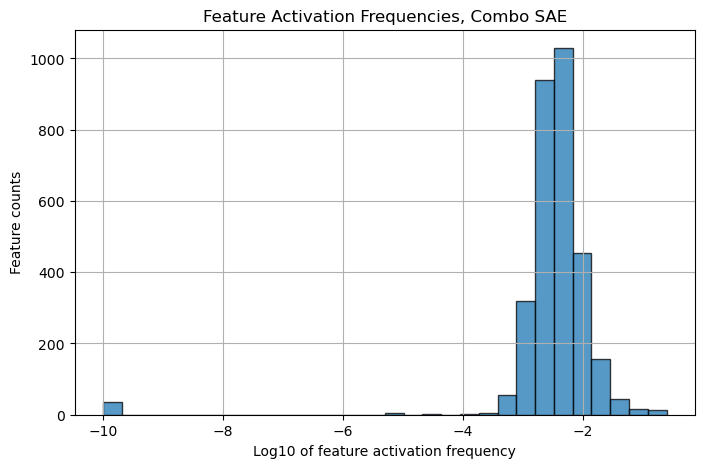

In [52]:
# plot log10 of feature activation frequencies (also called feature density) 
log_frequencies = np.log10(feature_frequencies + 1e-10)  # avoid log 0 

plt.figure(figsize=(8, 5))
plt.hist(log_frequencies, bins=30, edgecolor="black", alpha=0.75)
plt.xlabel("Log10 of feature activation frequency")
plt.ylabel("Feature counts")
plt.title("Feature Activation Frequencies, Combo SAE")
plt.grid(True)
plt.show()